In [111]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

from torchvision import transforms
from torch.autograd import Variable

from PIL import Image

In [112]:
'''%load_ext autoreload
%autoreload 2

#import sys
#sys.path.insert(0, 'deep_dream.py')

from deep_dream import DeepDream

import imp
imp.reload(DeepDream)'''

import sys

import torch
import torch.optim as optim

class DeepDream:
    def __init__(self, forward_func):
        self.forward_func = forward_func

    # TODO move some of the args into kwargs and support additional forward args
    def dream(self,
              inputs,
              optimizer=optim.SGD,
              optimizer_params={'lr': 12, 'weight_decay':1e-4},
              objective=torch.sum,
              num_iter=500,
              target=None,
              layer=None,
              transform=None,
              return_generated_inputs=True,
              verbose=True,
              logger=sys.stdout,
              lag=100):
  
            optimizer = self._create_optimizer(optimizer, inputs, optimizer_params)

            if return_generated_inputs:
                generated_inputs = []

            layer_out = None
            def forward_hook(module, inputs, outputs):
                nonlocal layer_out
                # In a general case, it is good to clone the tensor
                # in case inplace operations on the tensor take place
                layer_out = outputs.clone()

            # if layer is not provided, forward hook will not be used and
            # the output of the model will be used instead    
            if layer is not None:
                handle = layer.register_forward_hook(forward_hook)

            for i in range(num_iter):
                optimizer.zero_grad()
                inputs_ = inputs()
                input_transformed = inputs_
                if transform is not None:
                    input_transformed, image_vis = transform(inputs_)

                output = self.forward_func(input_transformed)

                if layer_out is not None:
                    output = layer_out

                if target is not None:
                   # TODO replace this with `_select_targets` function
                    output = layer_out[target]

                loss = -1 * objective(output)

                # compute gradient of the loss with respect to data points
                loss.backward()

                # update data points
                # instead of using optimizer.step we could, alternatively, update
                # data here using the learning rate but using optimizers instead
                # since they can offer more flexibility
                optimizer.step()

                if i % lag == 0:
                    if verbose:
                        logger.write("Loss: {}\n".format(-loss.cpu().detach()))
                    if return_generated_inputs is not None:
                        generated_inputs.append(image_vis.clone().detach())

            if layer is not None:
                handle.remove()

            if return_generated_inputs:
                return generated_inputs
            return input_transformed.clone().detach()
 
    def _create_optimizer(self, optimizer, input, optimizer_params=None):
        return optimizer(input.X, **optimizer_params)


In [113]:
net = models.googlenet(pretrained=True)
net.cuda()
net.eval()


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [114]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

class Laplacian_Image(torch.nn.Module):

    def __init__(self):
        super(Laplacian_Image, self).__init__()
        power = 0.1
        X = []
        scaler = []
        for scale in [1,2,4,8,16,32]:
            upsample = torch.nn.Upsample(scale_factor = scale, mode='nearest')
            x = torch.randn([1, 3, 224//scale, 224//scale])/10
            x = x.cuda()
            x = x*(scale**power)/(32**power)
            x.requires_grad = True
            X.append(x)
            scaler.append(upsample)

        self.X = X
        self.scaler = scaler

    def forward(self):
        A = []
        for xi, upsamplei in zip(self.X, self.scaler):
            A.append(upsamplei(xi))
        return torch.sum(torch.cat(A), 0) + 0.5


normalize = transforms.Normalize(mean=mean, std=std)

mean = torch.tensor(mean)[None,:,None,None]
std  = torch.tensor(std)[None,:,None,None]

def denormalize(x):
    return (std*x + mean)

def jitter(x, pad_width=2, pad_value=1.1):
    N, C, H, W = x.shape
    y = F.pad(x, 4 * (pad_width,), value=pad_value)
    idx, idy = np.random.randint(low=0, high=2*pad_width, size=(2,))
    return y[:, :, idx:idx+H, idy:idy+W]

def color_correction():
    S = np.asarray([[0.26, 0.09, 0.02],
                  [0.27, 0.00, -0.05],
                  [0.27, -0.09, 0.03]]).astype("float32")
    C = S / np.max(np.linalg.norm(S, axis=0))
    C = torch.tensor(C)
    return C.transpose(0,1)

def upsample():
    upsample = torch.nn.Upsample(scale_factor = 1.1, mode='bilinear')
    def up(x):
        upsample.x = (1 + np.random.randn(1)[0]/50, 1 + np.random.randn(1)[0]/50)
        return upsample(x)
    return up

C = color_correction().cuda()

up = upsample()

def preprocess_image(image):
    x0 = (image.reshape(3,224*224).transpose(0,1) @ C).transpose(0,1).reshape(1,3,224,224)
    x1 = torch.sigmoid(x0)
    x2 = normalize(x1[0]).unsqueeze(0)
    x3 = jitter(x2, pad_width=3)
    x4 = up(x3)
    return x4, x2


In [115]:
def create_random_image():
    image = torch.randn([1, 3, 224, 224])/10 + 0.5
    #image = preprocess_image(image.cuda())
    image = image.cuda()
    image.requires_grad = True
    return image


def create_laplacian_image():
    return Laplacian_Image()

In [116]:
dd = DeepDream(net)

Loss: 0.5939200520515442
Loss: 17.738067626953125
Loss: 23.087360382080078
Loss: 24.967716217041016
Loss: 24.60253143310547


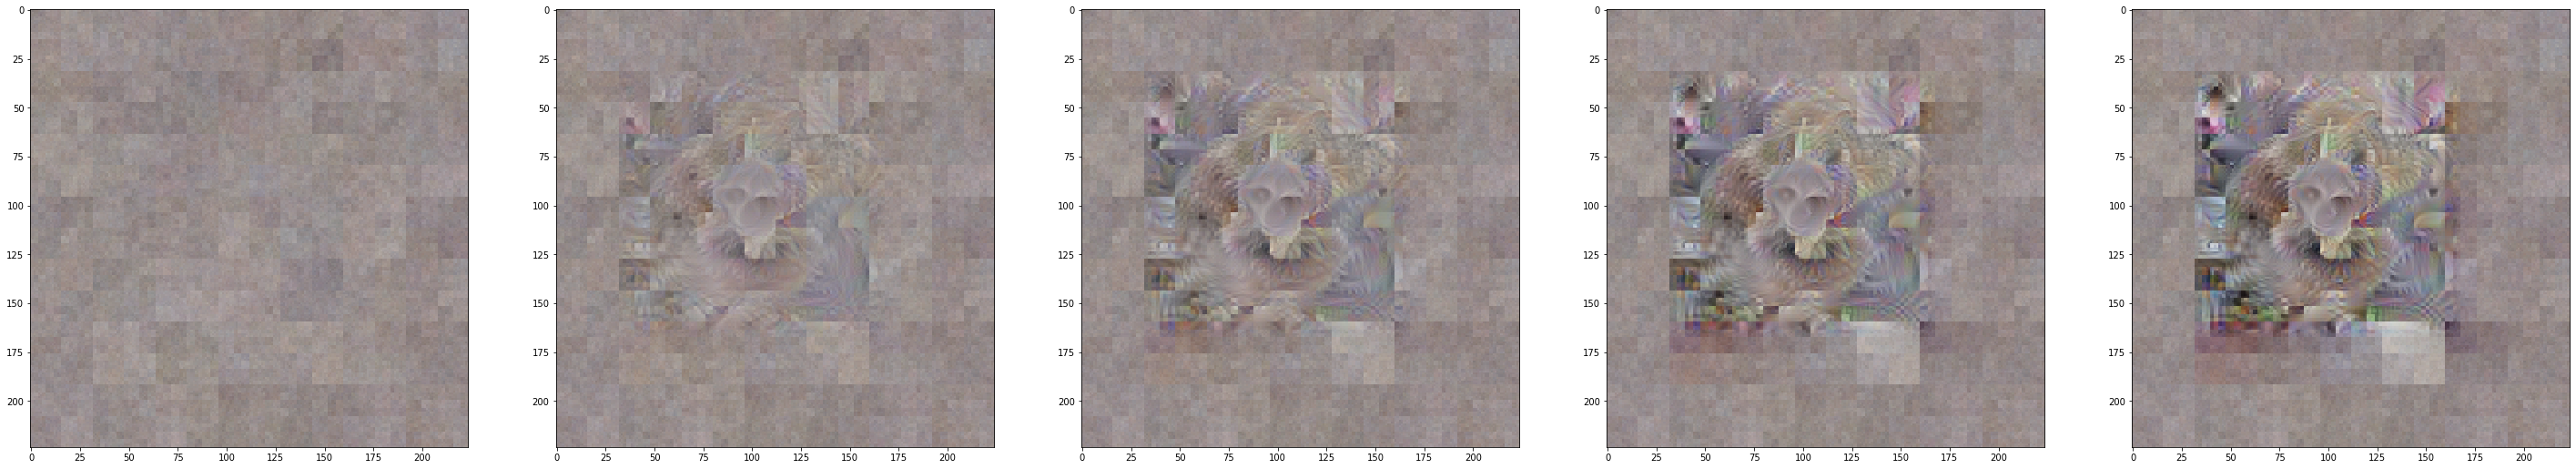

Loss: 0.17331336438655853
Loss: 11.433069229125977
Loss: 14.066540718078613
Loss: 14.184890747070312
Loss: 16.79471206665039


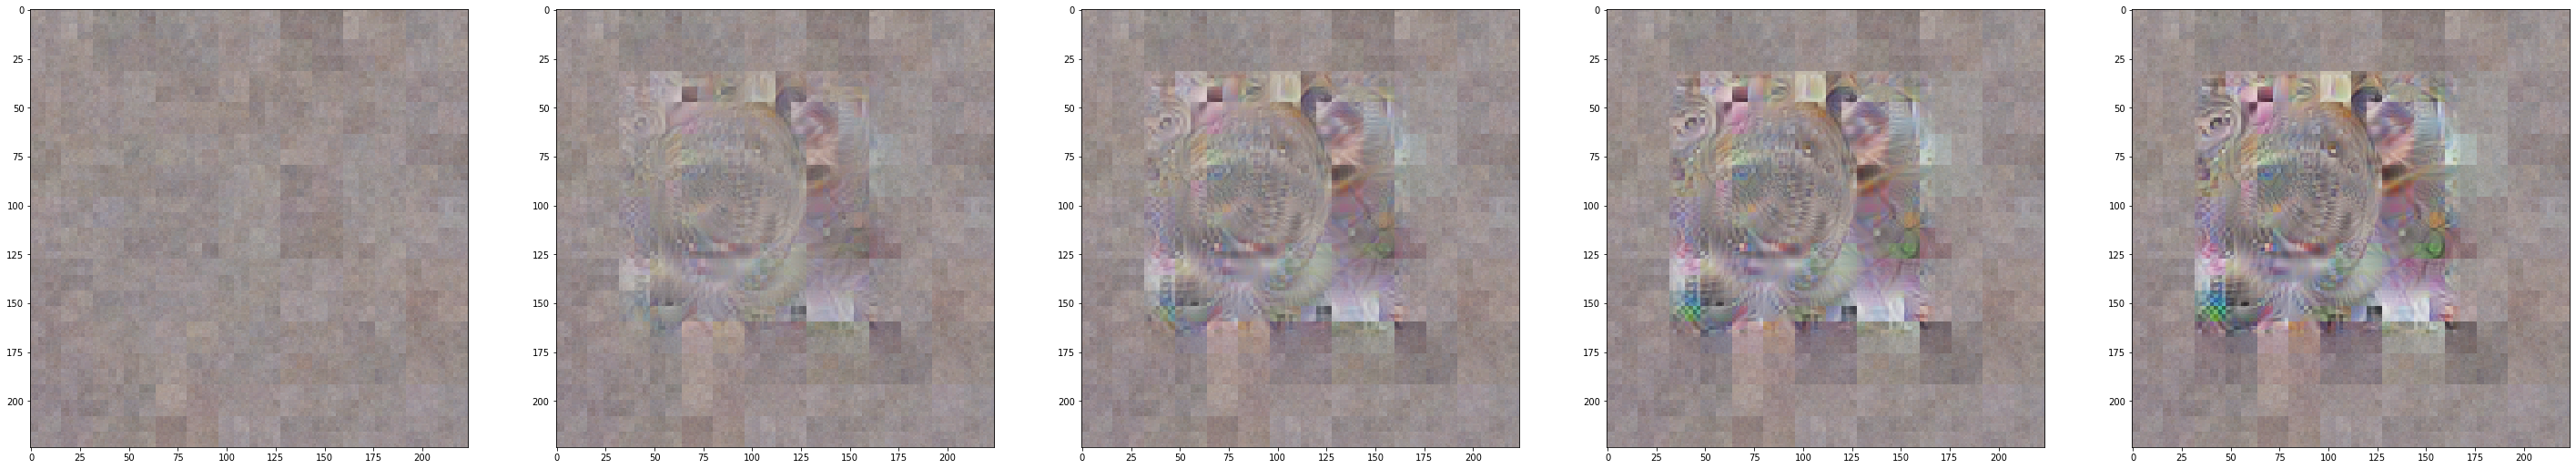

In [119]:
num_iter = 500

#target=(0, 2)
image = create_laplacian_image()
generated_inputs = dd.dream(image, optimizer=optim.Adam, optimizer_params={'lr': 0.005}, num_iter=num_iter, target=(0, 2, 6, 6), layer=net.inception4c, transform=preprocess_image, lag=100, return_generated_inputs=True, verbose=True)
f,ax = plt.subplots(1,num_iter // 100, figsize=(50,100))
for i, generated_input in enumerate(generated_inputs):
    ax[i].imshow((denormalize(generated_input.cpu()).detach().numpy()[0].transpose(1,2,0)* 255).astype(np.uint8))
plt.show()

image = create_laplacian_image()
generated_inputs = dd.dream(image, optimizer=optim.Adam, optimizer_params={'lr': 0.005}, num_iter=num_iter, target=(0, 1, 6, 6), layer=net.inception4c, transform=preprocess_image, lag=100, return_generated_inputs=True, verbose=True)
f,ax = plt.subplots(1,num_iter // 100, figsize=(50,100))
for i, generated_input in enumerate(generated_inputs):
    ax[i].imshow((denormalize(generated_input.cpu()).detach().numpy()[0].transpose(1,2,0)* 255).astype(np.uint8))
plt.show()   


In [13]:
import copy 
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((224, 224))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    #im_as_var = Variable(im_as_ten)
    return im_as_ten


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

im_path = 'img/sky-dd.jpeg'
created_image = Image.open(im_path).convert('RGB')
processed_image = preprocess_image(created_image, True)
processed_image = processed_image.cuda()
processed_image.requires_grad_(True)
print(processed_image.device)
outputs = dd.dream(processed_image, target=(0, 2, 3), layer=net.inception4c, optimizer_params={'lr': 12, 'weight_decay':1e-4})

for i, output in enumerate(outputs):
        created_image = recreate_image(output.cpu().detach())
        plt.imshow(created_image)
        plt.show()

cuda:0


UnboundLocalError: local variable 'image_vis' referenced before assignment